<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/06__Transfer_Learning_with_TensorFlow_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-12 04:37:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-12 04:37:03 (95.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

#Downloading and preprocessing the data

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-05-12 04:37:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  96.3MB/s    in 15s     

2024-05-12 04:37:23 (106 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:

# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caesar_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_class

In [5]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode="categorical",
                                                                              image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#Train a big model with transfer learning on 10% of 101 food classes

following modelling setup:

A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time

Data augmentation built right into the model

A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model

A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

Categorical crossentropy as the loss function since we're dealing with more than two classes

The Adam optimizer with the default settings
Fitting for 5 full passes on the training data while evaluating on 15% of the test data

In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weight_only=True, #save only the model weights
                                                       monitor="val-accuracy", # save the model weights which score the best validation accurac
                                                       save_best_only=True # only keep the best model weights on file (delete the rest)
                                                       )

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
#Create data augmentetion layer

data_augmentation=Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
])

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers

inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)  # augment images (only happens during training)
x=base_model(x,training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x=layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [10]:
#Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

In [11]:
#Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
#Fit the mode
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)), # evaluate on 15%
                                         callbacks=[checkpoint_callback]
                                         )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3949 - accuracy: 0.2710

237/237 [==============================] - 155s 606ms/step - loss: 3.3949 - accuracy: 0.2710 - val_loss: 2.4687 - val_accuracy: 0.4629
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.1939 - accuracy: 0.5011

237/237 [==============================] - 103s 433ms/step - loss: 2.1939 - accuracy: 0.5011 - val_loss: 1.9877 - val_accuracy: 0.5193
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8199 - accuracy: 0.5670

237/237 [==============================] - 94s 394ms/step - loss: 1.8199 - accuracy: 0.5670 - val_loss: 1.8722 - val_accuracy: 0.5310
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.6048 - accuracy: 0.6139

237/237 [==============================] - 83s 349ms/step - loss: 1.6048 - accuracy: 0.6139 - val_loss: 1.7976 - val_accuracy: 0.5326
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4564 - accuracy: 0.6388

237/237 [==============================] - 71s 297ms/step - loss: 1.4564 - accuracy: 0.6388 - val_loss: 1.7480 - val_accuracy: 0.5482


In [13]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 59s 75ms/step - loss: 1.5861 - accuracy: 0.5839


[1.5861308574676514, 0.5838811993598938]

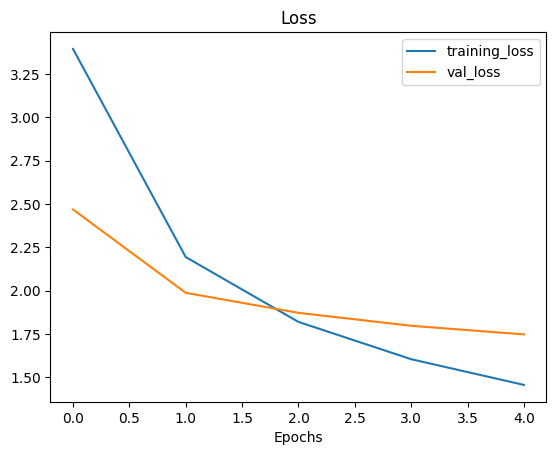

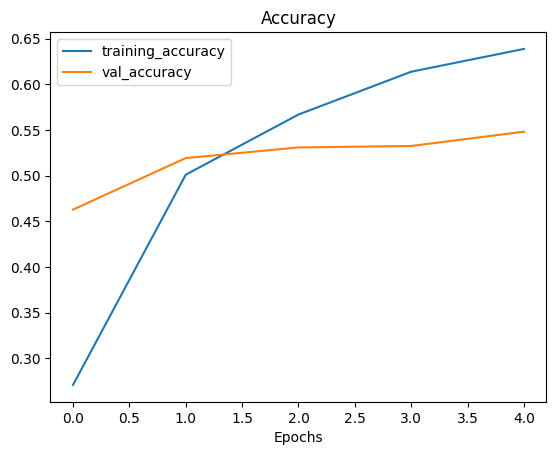

In [14]:
plot_loss_curves(history_all_classes_10_percent)

#Fine-tuning

In [15]:
#Unfreeze all layers in the base model
base_model.trainable=True

#Refreeze evry layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [16]:
#Recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower learning rate than default
              metrics=["accuracy"]
              )

In [17]:
# Check what layers are trainable
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
sequential True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
# Check which layers are trainable
#for layer_number, layer in enumerate(base_model.layers):
  #print(layer_number, layer.name, layer.trainable)

In [19]:
#Fine tune for 5 epochs more
fine_tune_epochs=10 #5+5 from previews
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 83s 313ms/step - loss: 1.2102 - accuracy: 0.6855 - val_loss: 1.6946 - val_accuracy: 0.5508
Epoch 6/10
237/237 [==============================] - 64s 268ms/step - loss: 1.1042 - accuracy: 0.7100 - val_loss: 1.7178 - val_accuracy: 0.5493
Epoch 7/10
237/237 [==============================] - 63s 263ms/step - loss: 1.0141 - accuracy: 0.7302 - val_loss: 1.7422 - val_accuracy: 0.5469
Epoch 8/10
237/237 [==============================] - 61s 254ms/step - loss: 0.9482 - accuracy: 0.7494 - val_loss: 1.6992 - val_accuracy: 0.5569
Epoch 9/10
237/237 [==============================] - 61s 256ms/step - loss: 0.8774 - accuracy: 0.7637 - val_loss: 1.6990 - val_accuracy: 0.5561
Epoch 10/10
237/237 [==============================] - 55s 232ms/step - loss: 0.8370 - accuracy: 0.7748 - val_loss: 1.7226 - val_accuracy: 0.5514


In [20]:
# Evaluate the fien tune model
results_fine_tune_model=model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 59s 75ms/step - loss: 1.5103 - accuracy: 0.6026


[1.510252594947815, 0.6026138663291931]

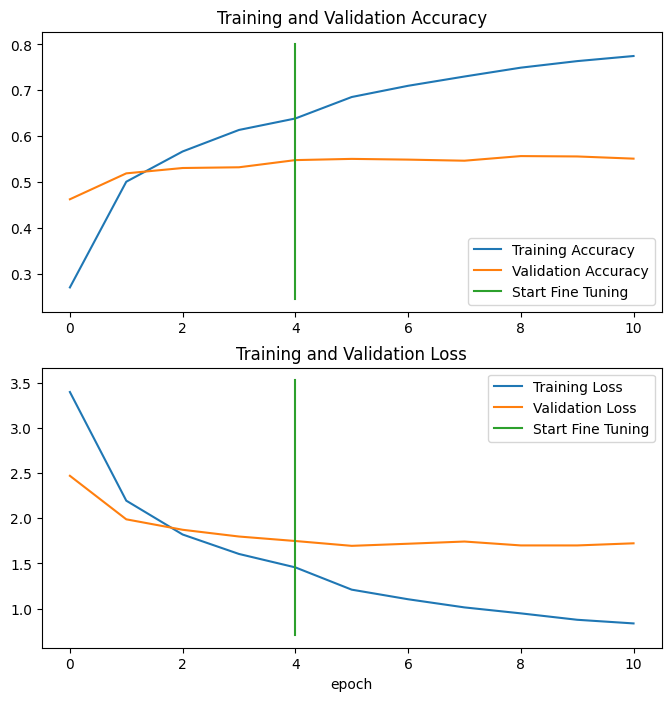

In [21]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [22]:
# # Save model to drive so it can be used later
# model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

# Evaluating the performance of a pre-trainded  model


In [23]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path


--2024-05-12 04:57:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   104MB/s    in 0.4s    

2024-05-12 04:57:10 (104 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [24]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 60s 73ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027204275131226, 0.6077623963356018)

In [25]:
#Make prediction
pred_probs=model.predict(test_data,verbose=1)  # set verbosity to see how long it will take

790/790 [==============================] - 61s 74ms/step


In [26]:
#How many predicts?
len(pred_probs)

25250

In [27]:
pred_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [28]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-

In [29]:
#Get the class predictions for each label
pred_classes=pred_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [30]:
y_labels=[]
for images,labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
# How many labels
len(y_labels)

25250

#Evaluating model predictions

-Scikit-Learn's accuracy_score() function which compares truth labels to predicted labels and returns an accuracy score.

In [32]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score

sklearn_accuracy=accuracy_score(y_labels,pred_classes)
sklearn_accuracy



0.6077623762376237

In [33]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [34]:

# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [35]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)


In [36]:
#Scikit-Learn's classification_report() function.
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [37]:
#Get a dictionary of the classification report
classification_report_dict=classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [38]:
#Create an empty dictionary
class_f1_scores={}
# Loop through classification report items
for k,v in classification_report_dict.items():
  if k=="accuracy": # stop once we get to accuracy key
    break
  else:
    #Append class names and f1-scores to new dictionnary
    class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [39]:
#Turn f1-scoresinto dataframe for visualization
import pandas as pd
f1_scores=pd.DataFrame({"class_name":list(class_f1_scores.keys()),
                        "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

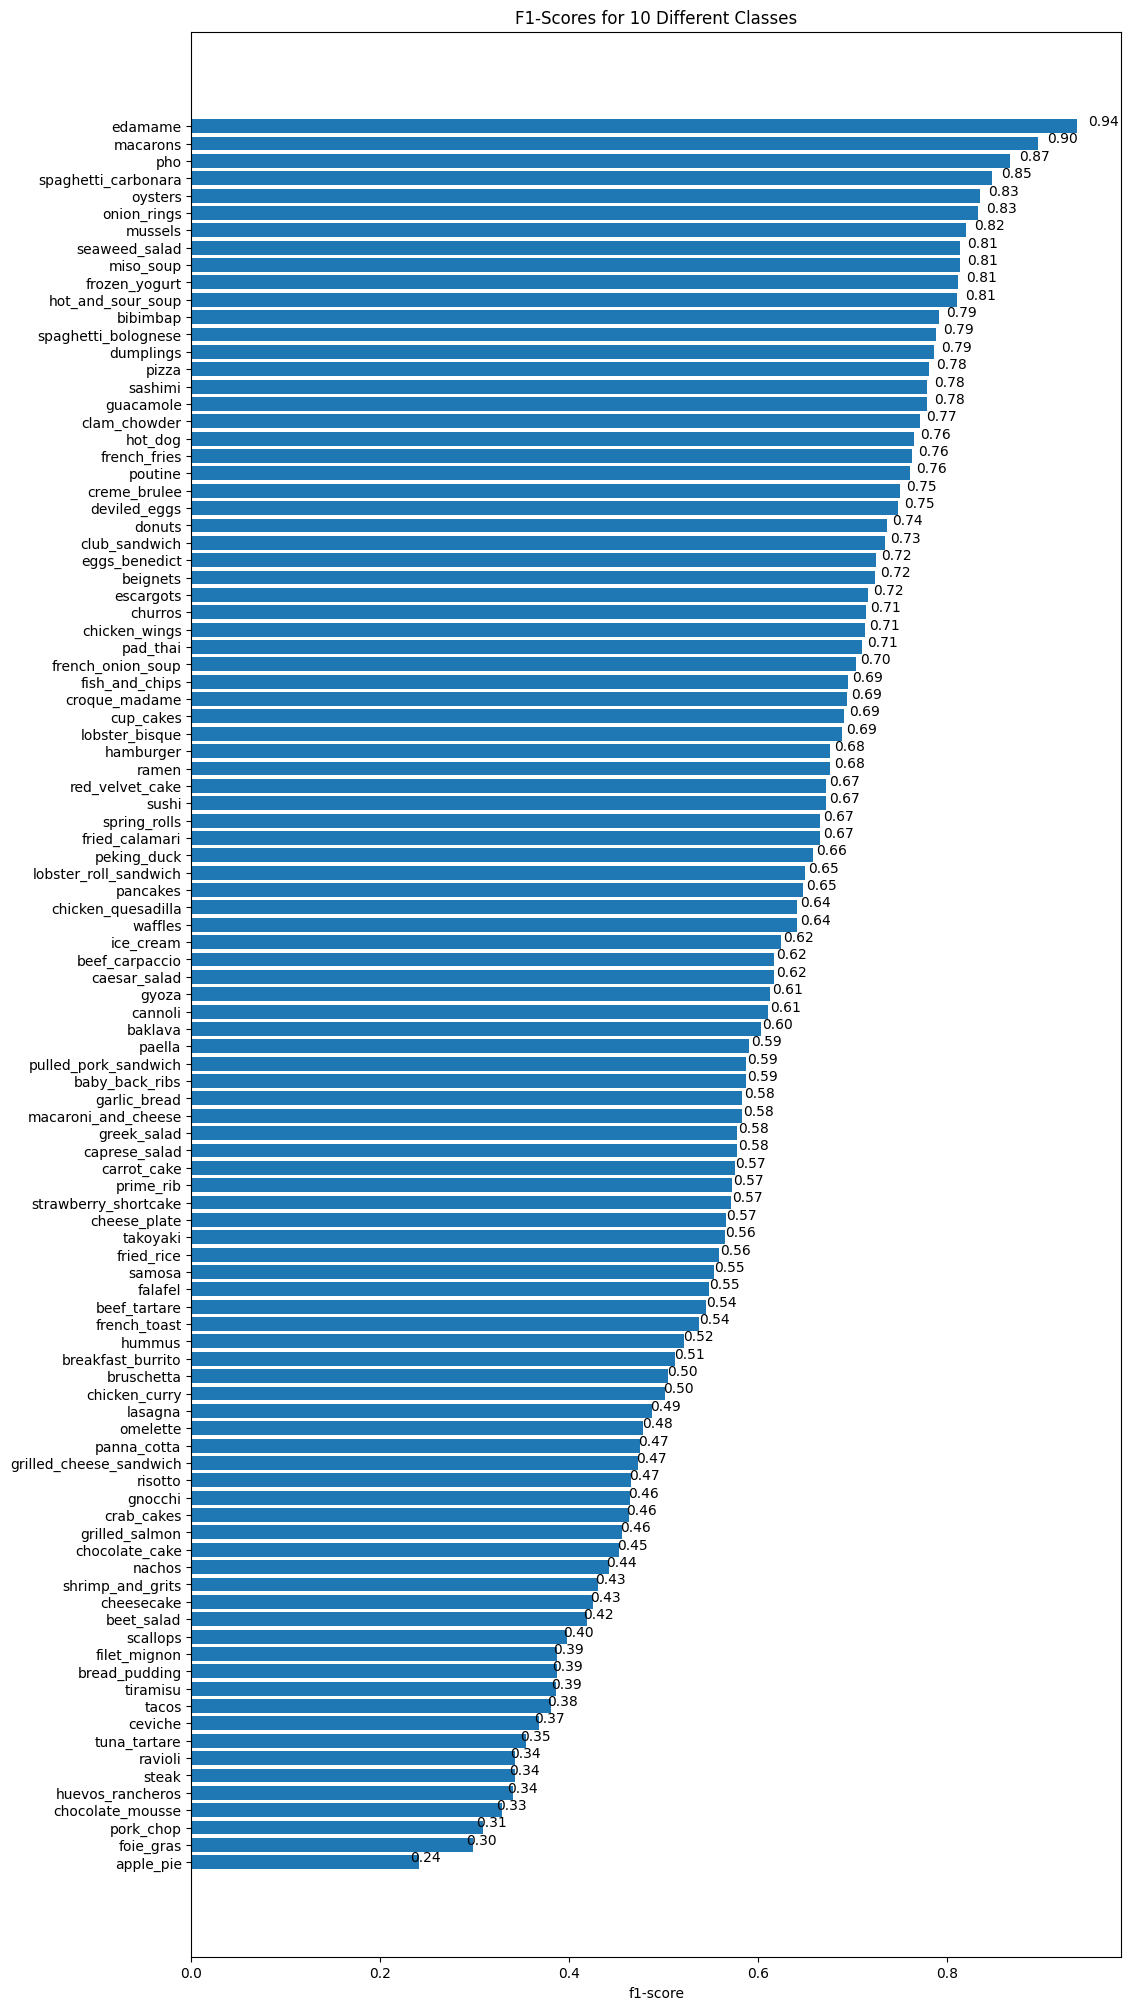

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

#Visualizing predictions on test images

In [41]:
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """

  #Read in the image
  img=tf.io.read_file(filename)
  #Decode it into a tensor
  img=tf.io.decode_image(img)
  #Resize the image
  img=tf.image.resize(img,[img_shape,img_shape])
  if scale:
    #Rescale the image (get values between 0-1)
    return img/225.
  else:
    return img


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


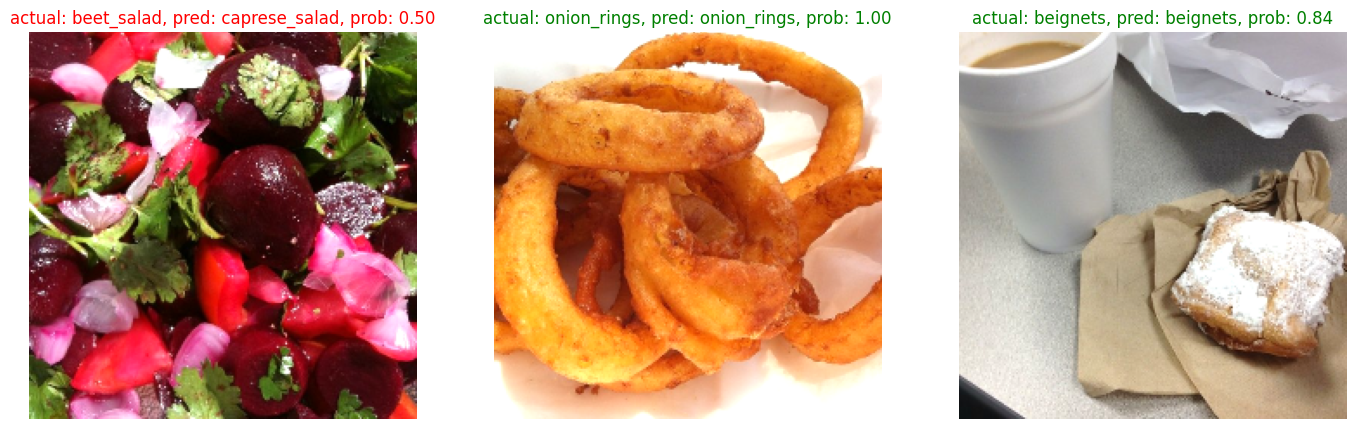

In [50]:
#Make predictions on a series of images
import os
import random

plt.figure(figsize=(17,20))
for i in range(3):
  #Choose a random image from a random class
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir + '/' + class_name))
  filepath=test_dir + class_name + "/" +filename
  #Load the image and make prediction

  img=load_and_prep_image(filepath,scale=False) #false for Efficentet
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class=class_names[pred_prob.argmax()] #find the predicted class

  #Plot the images

  plt.subplot(1,3, i+1)
  plt.imshow(img/225.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);



#Finding the most wrong predictions

steps:

Get all of the image file paths in the test dataset using the list_files() method.

Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.

Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.

Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).

Sort the DataFrame based on wrong predictions and highest max prediction probabilities.

Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [55]:
#Get the filenames of all of or test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [58]:
#Create a dataframe out of currrent prediction data for analysis

import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847418        apple_pie                 gyoza  
1   0.964017        apple_pie             apple_pie  
2   0.959259        apple_pie             apple_pie  
3   0.658607        apple_pie  pulled_pork_sandwich  
4   0.367901        apple_pie             prime_rib

In [59]:
#Check if the prediction is correct
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [60]:
#  Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False